#### Dataset
dog_dataset/images and annotations

Parse Annotation File(xml):  
Python provides the ElementTree API to load and parse an XML file
find() and findall() perform the XPath to extract data needed
- size: shape of the photo
- object: bounding box of the objects

In [8]:
from xml.etree import ElementTree

# function to extract bounding boxes from an annotation file
def extract_boxes(filename):
    # load and parse the file
    tree = ElementTree.parse(filename)
    # get the root of the document
    root = tree.getroot()
    # extract each bounding box
    boxes = list()
    for box in root.findall('.//bndbox'):
        xmin = int(box.find('xmin').text)
        ymin = int(box.find('ymin').text)
        xmax = int(box.find('xmax').text)
        ymax = int(box.find('ymax').text)
        coors = [xmin, ymin, xmax, ymax]
        boxes.append(coors)
    # extract image dimensions
    width = int(root.find('.//size/width').text)
    height = int(root.find('.//size/height').text)
    return boxes, width, height

In [92]:
#Test the function
annDir = './dataset/dog/annotations/xmls/'
(boxes, w, h) = extract_boxes(annDir+'dog_002.xml')

In [93]:
print(boxes, w, h)

[[116, 148, 428, 313]] 640 480


#### Dataset Object
    mask-rcnn datasets are managed by mrcnn.utils.Dataset object
    define a new class from mrcnn.utils.Dataset class and methods:
    
    load_dataset(self, dataset_dir, is_train)  
        defining the classes:
        self.add_class('dataset', 'class_id', 'class_name')
        define the "images info" dictionary in the datase:
        self.add_image('dataset', image_id, path, annotation)
        
    load_mask(image_id)
        image_id assigned by add_image(), with image info dictionary
        self.image_info[image_id]['annotation'] get the annotation file
        parse annotation file via extract_boxes()
        return an array of 'masks' in an image (mark 1 for object)
        All objects have the same class in this dataset:
            self.class_names.index['class_name']
        
    load image reference
        return the path for a given image_id
        self.image_info[image_id]['path']

In [12]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset

class DogDataset(Dataset):
    # load dataset definitions and images
    def load_dataset(self, dataset_dir, is_train=True):
    #def load_dataset(self, dataset_dir):
        #define the class
        self.add_class("dataset", 1, "dog")
        #data locations
        img_dir = dataset_dir+'/images/'
        ann_dir = dataset_dir+'/annotations/xmls/'
        for filename in listdir(img_dir):
            image_id = filename[4:-4] # extract id of image dog_001.jpg
        
            # trainset: 1-40
            if is_train and int(image_id) > 40:
                continue
            # testset: 41-50
            if not is_train and int(image_id) <= 40:
                continue
        
            img_path = img_dir + filename
            ann_path = ann_dir + filename[:-4] + '.xml'
            # add image to dataset
            self.add_image('dataset', image_id = image_id, 
                           path=img_path, annotation=ann_path)
    
    # load the masks for an image    
    def load_mask(self, image_id):
        # get image info dictionary
        info = self.image_info[image_id]
        # get the annotation file
        ann_file = info['annotation']
        # parse ann file
        (boxes, w, h) = extract_boxes(ann_file)
        
        #create masks (each mask on a different channel)
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            ymin, ymax = box[1], box[3]
            xmin, xmax = box[0], box[2]
            masks[ymin:ymax, xmin:xmax, i] = 1
            class_ids.append(self.class_names.index('dog'))
        return masks, asarray(class_ids, dtype='int32')
    
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

#### Split Train and Test

In [13]:
dataset_dir = './dataset/dog'
train = DogDataset()
train.load_dataset(dataset_dir, is_train=True)
train.prepare()

test = DogDataset()
test.load_dataset(dataset_dir, is_train=False)
test.prepare()

In [14]:
len(train.image_ids)

40

In [12]:
train.class_names.index('BG')

0

#### Test on one image
load_image(image_id): load an image via id
load_mask(image_id): load the mask for the image  
both arrays have the same dimension but different channels
mrcnn.utils.extract_bboxes(mask): extract bounding box via mask
mrcnn.visualize.display_instances(image,bbox,mask,class_id,class_names)

In [4]:
for image_id in test.image_ids:
    info = test.image_info[image_id]
    print(info)

{'id': '041', 'source': 'dataset', 'path': './dataset/dog/images/dog_041.jpg', 'annotation': './dataset/dog/annotations/xmls/dog_041.xml'}
{'id': '042', 'source': 'dataset', 'path': './dataset/dog/images/dog_042.jpg', 'annotation': './dataset/dog/annotations/xmls/dog_042.xml'}
{'id': '043', 'source': 'dataset', 'path': './dataset/dog/images/dog_043.jpg', 'annotation': './dataset/dog/annotations/xmls/dog_043.xml'}
{'id': '044', 'source': 'dataset', 'path': './dataset/dog/images/dog_044.jpg', 'annotation': './dataset/dog/annotations/xmls/dog_044.xml'}
{'id': '045', 'source': 'dataset', 'path': './dataset/dog/images/dog_045.jpg', 'annotation': './dataset/dog/annotations/xmls/dog_045.xml'}
{'id': '046', 'source': 'dataset', 'path': './dataset/dog/images/dog_046.jpg', 'annotation': './dataset/dog/annotations/xmls/dog_046.xml'}
{'id': '047', 'source': 'dataset', 'path': './dataset/dog/images/dog_047.jpg', 'annotation': './dataset/dog/annotations/xmls/dog_047.xml'}
{'id': '048', 'source': 'da

(480, 640, 3)
(480, 640, 1)


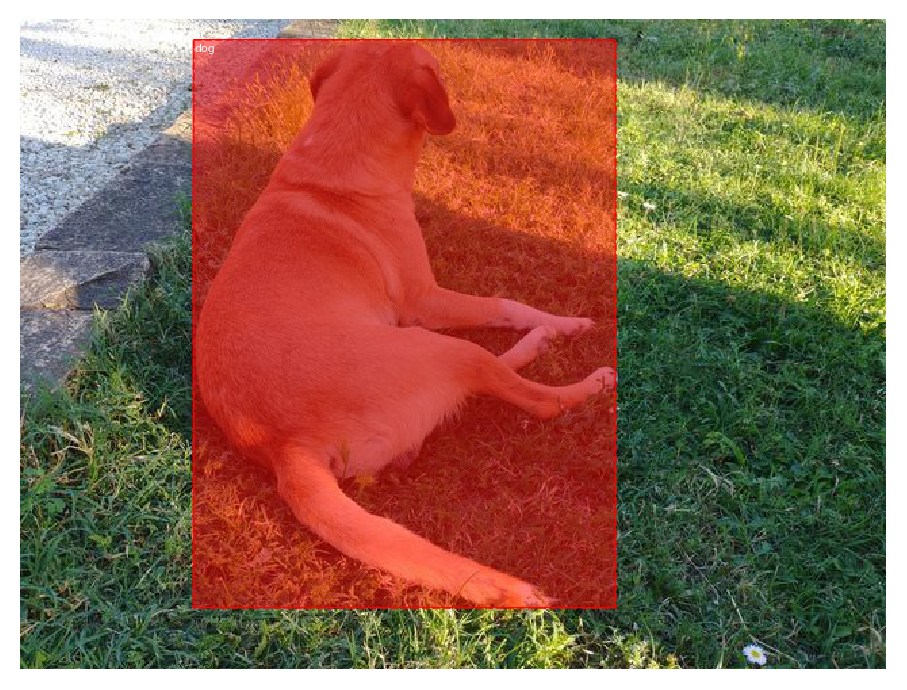

In [104]:
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes

image_id = 5
image = train.load_image(image_id)
print(image.shape)
mask, class_ids = train.load_mask(image_id)
print(mask.shape)
bbox = extract_bboxes(mask)
display_instances(image, bbox, mask, class_ids, train.class_names)

#### Training
Define config from mrcnn.config.Config class:  
- prediction problem (such as NAME and the NUM_CLASSES)
- the algorithm for training the model (such as the learning rate)

Create Model:
- mrcnn.model.MaskRCNN(mode, model_dir, config)
- model.load_weights(weights, by_name)

Fit Model:
- model.train(train_set, test_set, learning_rate, epoch, layers)

For Objection detection, check loss for classification and bbox:
- mrcnn_class_loss and val_mrcnn_class_loss
- mrcnn_bbox_loss and val_mrcnn_bbox_loss

In [48]:
from mrcnn.config import Config
from mrcnn.model import MaskRCNN

class DogConfig(Config):
    NAME = "dog_cfg"
    NUM_CLASSES = 1 + 1
    STEPS_PER_EPOCH = 40
    #GPU_COUNT = 1
    #IMAGES_PER_GPU = 1
    IMAGE_MAX_DIM = 640
    IMAGE_MIN_DIM = 480
    #LEARNING_RATE = 0.01
    #TRAIN_ROIS_PER_IMAGE = 2

config = DogConfig()
#config.display()

In [49]:
model = MaskRCNN(mode='training', model_dir='./models', config=config)

the class-specific output layers will be removed so that new output layers can be defined and trained. 
This can be done by specifying the ‘exclude‘ argument and listing all of the output layers to exclude or remove from the model after it is loaded. This includes the output layers for the classification label, bounding boxes, and masks.
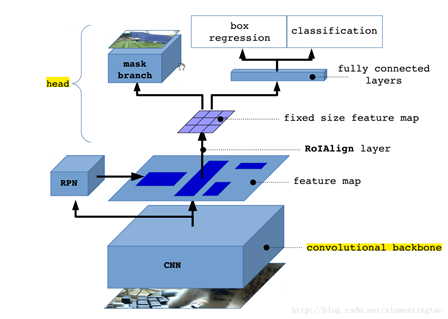

In [50]:
model.load_weights('./models/mask_rcnn_coco.h5', by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                            "mrcnn_bbox", "mrcnn_mask"])

the model can be fit on the training dataset by calling the train() function and passing in both the training dataset and the validation dataset. We can also specify the learning rate as the default learning rate in the configuration (0.001).
We can also specify what layers to train. In this case, we will only train the heads, that is the output layers of the model.

In [51]:
# need keras v2.2.5 here
model.train(train, test, learning_rate=config.LEARNING_RATE, 
            epochs=5, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./models/dog_cfg20191212T1118/mask_rcnn_dog_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (Ti

/home/litzen/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/litzen/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/litzen/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/litzen/anaconda3/lib/python3.7/site-packages/keras/engine/training_generator.py:49

Epoch 1/5
40/40 [==============================] - 2730s 68s/step - loss: 1.1660 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0279 - mrcnn_class_loss: 0.0451 - mrcnn_bbox_loss: 0.3694 - mrcnn_mask_loss: 0.7224 - val_loss: 1.0755 - val_rpn_class_loss: 0.0031 - val_rpn_bbox_loss: 0.1196 - val_mrcnn_class_loss: 0.0029 - val_mrcnn_bbox_loss: 0.3141 - val_mrcnn_mask_loss: 0.6358
Epoch 2/5
40/40 [==============================] - 2458s 61s/step - loss: 0.6618 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0470 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.1158 - mrcnn_mask_loss: 0.4925 - val_loss: 0.9882 - val_rpn_class_loss: 0.0020 - val_rpn_bbox_loss: 0.0871 - val_mrcnn_class_loss: 0.0013 - val_mrcnn_bbox_loss: 0.2206 - val_mrcnn_mask_loss: 0.6771
Epoch 3/5
40/40 [==============================] - 4420s 111s/step - loss: 0.6504 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0430 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0655 - mrcnn_mask_loss: 0.5390 - val_loss: 1.0038 - val_rpn_class_los

In [ ]:
#model.load_weights('.\dataset\dog\dog_cfg20191130T0031\mask_rcnn_dog_cfg_0003.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])
#model.train(train, test, learning_rate=config.LEARNING_RATE, epochs=5, layers='heads')

#### Run Object Detection
load the image and convert it to a NumPy array
- keras.preprocessing.image: load_img(), img_to_array()
- skimage.io.imread()

The result is a list containing a dictionary for each image.

The dictionary has keys and each key points to a list for multiple possible objects detected in the image.  

The keys of the dictionary of note are as follows:  
- 'rois': The bound boxes or regions-of-interest (ROI) for detected objects.  
- 'masks': The masks for the detected objects. 
- 'class_ids': The class integers for the detected objects.  
- 'scores': The probability or confidence for each predicted class.  

In [2]:
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
class Prediction(Config):
    NAME = 'dog_cfg'
    NUM_CLASSES = 1 + 1
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    #IMAGE_MAX_DIM = 640
    #IMAGE_MIN_DIM = 0


cfg = Prediction()
model = MaskRCNN(mode="inference", model_dir='./models/', config=cfg)
model.load_weights('./models/lr_001/mask_rcnn_dog_cfg_0005.h5', by_name=True)
#model.load_weights('./models/mask_rcnn_coco.h5', by_name=True)

Using TensorFlow backend.









Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.








In [57]:
import os
import numpy 
#img_dir = './dataset/dog/images/'
# Load a random image from the images folder
#file_names = next(os.walk(img_dir))[2]
file_names = 'dataset/dog/images/dog_043.jpg'

from keras.preprocessing import image
#img = image.load_img(os.path.join(img_dir, numpy.random.choice(file_names)))
img = image.load_img(file_names)
img = image.img_to_array(img)
img.shape
#import skimage.io
#image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

(480, 640, 3)

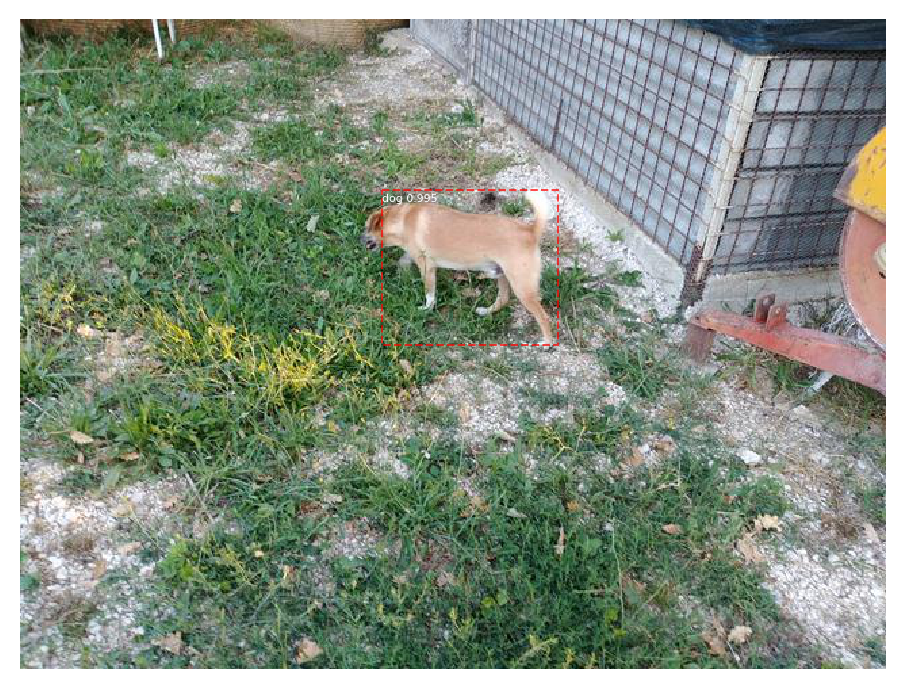

In [58]:
# Run detection
results = model.detect(images = [img], verbose=0)

# Visualize results
from mrcnn import visualize
r = results[0]
masks = numpy.zeros([480, 640, 1], dtype='uint8')
visualize.display_instances(img, r['rois'],  masks, r['class_ids'], ['BG', 'dog'], r['scores'])

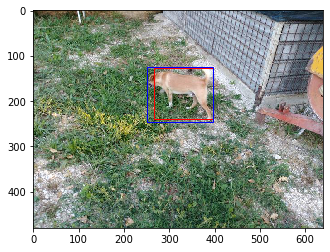

In [59]:
from matplotlib import pyplot
from matplotlib.patches import Rectangle

(boxes, w, h) = extract_boxes('dataset/dog/annotations/xmls/dog_043.xml')
x_1, y_1, x_2, y_2 = boxes[0]
w, h = x_2 - x_1, y_2 - y_1
# create the shape
rect2 = Rectangle((x_1, y_1), w, h, fill=False, color='blue')

# Run detection
results = model.detect(images = [img], verbose=0)
r = results[0]
y1, x1, y2, x2 = r['rois'][0]
# calculate width and height of the box
width, height = x2 - x1, y2 - y1
# create the shape
rect = Rectangle((x1, y1), width, height, fill=False, color='red')
data = pyplot.imread(file_names)
pyplot.imshow(data)
ax = pyplot.gca()
ax.add_patch(rect)
ax.add_patch(rect2)
pyplot.show()

#### Evaluation
Intersection over Union (IoU):
- the overlap of predicted and actual bounding boxes
mean Absolute Precision (mAP):
- percentage of the correctly predicted bounding boxes (IoU > 0.5)
    
define a new Config object to use for making predictions
- using the GPU for inference (batch size)
define a model with mode 'inference' and weight trained

load image and ground truth mask for a given image_id
- load_image_gt(dataset, config, image_id, use_mini_mask=False)
scale loaded image (same as the training data)
- mold_image(image, config)
expand dimensions of the image and make a prediction with the model
- numpy.expand_dims(image, 0)
- model.detect()

compare the prediction with the ground truth
- compute_ap(gt_bbox, gt_class_id, gt_mask, r)

In [15]:
class Prediction(Config):
    NAME = 'dog_cfg'
    NUM_CLASSES = 1 + 1
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

cfg = Prediction()
model = MaskRCNN(mode='inference', model_dir='./models', config=cfg)
model.load_weights('./models/lr_001/mask_rcnn_dog_cfg_0005.h5', by_name=True)

In [28]:
image_id = 5
(image, image_meta, gt_class_id, gt_bbox, gt_mask) = \
load_image_gt(train, cfg, image_id, use_mini_mask=False)

scaled_img = mold_image(image, cfg)
sample = expand_dims(scaled_img, 0)
yhat = model.detect(sample, verbose=0)
r = yhat[0]
(AP, a, b, c) = compute_ap(gt_bbox, gt_class_id, gt_mask,
                                r['rois'], r['class_ids'], r['scores'], r['masks'])
b

array([0., 1., 1.])

In [23]:
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from numpy import expand_dims
from numpy import mean

def evaluate_model(dataset, model, config):
    APs = list()
    for image_id in dataset.image_ids:
        (image, image_meta, gt_class_id, gt_bbox, gt_mask) = load_image_gt(dataset, config, image_id,
                                                                          use_mini_mask=False)
        scaled_img = mold_image(image, config)
        sample = expand_dims(scaled_img, 0)
        yhat = model.detect(sample, verbose=0)
        r = yhat[0]
        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask,
                                r['rois'], r['class_ids'], r['scores'], r['masks'])
        APs.append(AP)
    mAP = mean(APs)
    return mAP

In [24]:
train_mAP = evaluate_model(train, model, cfg)
print('train mAP: %.3f' % train_mAP)

train mAP: 0.750


In [60]:
test_mAP = evaluate_model(test, model, cfg)
test_mAP

0.5